In [1]:
import torch
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model import QuartzNetCTC

NOTE! Installing ujson may make loading annotations faster.


In [2]:
cfg = OmegaConf.load("./conf/quarznet_5x5_ru.yaml")

In [3]:
cfg

{'model': {'init_weights': None, 'enc_filters': 1024, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'encoder': {'repeat': 5, 'dropout': 0.0, 'feat_in': 64, 'blocks': [{'filters': 256, 'repeat': 1, 'kernel_size': 33, 'stride': 4, 'dilation': 1, 'residual': False, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 256, 'repeat': '${model.encoder.repeat}', 'kernel_size': 33, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 256, 'repeat': '${model.encoder.repeat}', 'kernel_size': 39, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 512, 'repeat': '${model.encoder.repeat}', 'kernel_size': 51, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 5

In [363]:
cfg.val_dataloader.batch_size = 100
cfg.val_dataloader.dataset.manifest_name = 'test_opus/crowd/manifest.jsonl'

In [364]:
model = QuartzNetCTC(cfg)
model.eval()
model.freeze()

ckpt = torch.load('data/q5x5_ru_stride_4_crowd_epoch_4_step_9794.ckpt', map_location='cpu')
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [365]:
model.to('cuda:2')

QuartzNetCTC(
  (encoder): QuartzNet(
    (layers): Sequential(
      (0): QuartzNetBlock(
        (conv): ModuleList(
          (0): Conv1d(64, 64, kernel_size=(33,), stride=(4,), padding=(16,), groups=64)
          (1): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
          (2): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU()
          (4): Dropout(p=0.0, inplace=False)
        )
        (out): Sequential(
          (0): ReLU()
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (1): QuartzNetBlock(
        (res): Sequential(
          (0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv): ModuleList(
          (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding=(16,), groups=256)
          (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
          (2): BatchNorm1d(256, eps=0.001

In [366]:
features_list, features_len_list = [], []
targets_list, target_len_list = [], []
logprobs_list, encoded_len_list, preds_list = [], [], []

for i, batch in tqdm(enumerate(model.val_dataloader())):
    features, features_len, targets, target_len = batch
    logprobs, encoded_len, preds = model.forward(features.to('cuda:2'), features_len.to('cuda:2'))
    features_list.append(features)
    features_len_list.append(features_len)
    targets_list.append(targets)
    target_len_list.append(target_len)
    logprobs_list.append(logprobs)
    encoded_len_list.append(encoded_len)
    preds_list.append(preds)
    if i == 5:
        break

5it [00:12,  2.55s/it]


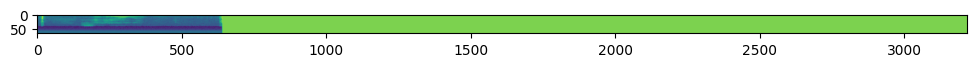

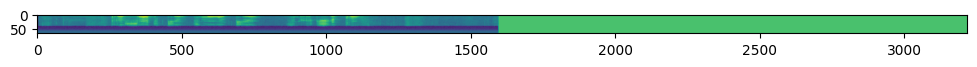

In [369]:
for feature in features[:2]:
    plt.figure(figsize=(12, 5))
    plt.imshow(feature)
    plt.show()

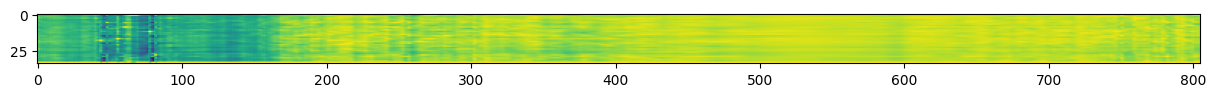

In [370]:
plt.figure(figsize=(15, 8))
plt.imshow(logprobs[0].T.cpu())
plt.show()

In [180]:
from src.metrics import WER

def calculate_greedy_wer(preds_list, encoded_len_list, targets_list):
    metric = WER()
    refs = []
    hyps = []
    for pred_batch, encoded_len_batch, targets_batch in tqdm(zip(preds_list, encoded_len_list, targets_list)):
        for pred, pred_len, target in zip(pred_batch, encoded_len_batch, targets_batch):
            hyps.append(model.decoder.decode_hypothesis(pred[:pred_len], unique_consecutive=True))
            refs.append(model.decoder.decode_hypothesis(target, unique_consecutive=False))
    
    metric.update(refs, hyps)
    wer = metric.compute()
    print(wer)

In [372]:
calculate_wer(preds_list, encoded_len_list, targets_list)

6it [00:05,  1.07it/s]

(tensor(0.2719), tensor(809.), tensor(2975.))


In [373]:
from torchaudio.models.decoder import ctc_decoder

In [374]:
tokens = cfg.model.labels + ['-']

In [375]:
import kenlm
LM_PATH = '/home/malex26/repos/speech-tech-mipt/week07/asr/kenlms/lm_50x50.binary'
lm_model = kenlm.LanguageModel(LM_PATH)

In [381]:
LM = '/home/malex26/repos/speech-tech-mipt/week07/asr/kenlms/lm_50x50.binary'

beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=tokens,
    nbest=5,
    beam_size=50,
    sil_token=' ',
    blank_token='-',
)
wer, oracle_wer, rescored_wer = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)

print('WER: ', wer)
print('Oracle WER: ', oracle_wer)
print('Rescored WER: ', rescored_wer)

6it [00:34,  5.72s/it]

WER:  tensor(0.2719)
Oracle WER:  tensor(0.2081)
Rescored WER:  tensor(0.2350)


In [380]:
def calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder):
    metric = WER()
    refs = []
    hyps = []
    best_hyps = []
    rescored_hyps = []
    # Iterating through dataloader
    for logprob_batch, encoded_len_batch, targets_batch in tqdm(zip(logprobs_list, encoded_len_list, targets_list)):
        beamsearch_result = beam_search_decoder(logprob_batch.cpu(), encoded_len_batch.cpu())
        
        # Iterating throug batch
        for i in range(len(beamsearch_result)):
            ref = model.decoder.decode_hypothesis(targets_batch[i], unique_consecutive=False)
            refs.append(ref)
            
            # Iterating through n-best
            best_distance = 10000
            best_hyp = None
            best_rescored_hyp = None
            best_score = -100000
            for j in range(len(beamsearch_result[i])):
                curr_tokens = beamsearch_result[i][j].tokens
                curr_hyp = model.decoder.decode(curr_tokens.unsqueeze(0), [len(curr_tokens)])[0]
                if j == 0:
                    hyps.append(curr_hyp)
                
                distance = editdistance.eval(ref.split(), curr_hyp.split())
                if distance < best_distance:
                    best_hyp = curr_hyp
                    best_distance = distance
                score = lm_model.score(curr_hyp)
                if score > best_score:
                    best_score = score
                    best_rescored_hyp = curr_hyp
                    
            best_hyps.append(best_hyp)
            rescored_hyps.append(best_rescored_hyp)
    
    metric.update(refs, hyps)
    wer = metric.compute()
    
    metric.reset()
    metric.update(refs, best_hyps)
    oracle_wer = metric.compute()
    
    metric.reset()
    metric.update(refs, rescored_hyps)
    rescored_wer = metric.compute()
    return wer[0], oracle_wer[0], rescored_wer[0]

In [382]:
BEAM_SIZE = 20
N_BESTS = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for n_best in N_BESTS:
    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=tokens,
        nbest=n_best,
        beam_size=BEAM_SIZE,
        sil_token=' ',
        blank_token='-',
    )
    wer, oracle_wer, rescored_wer = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
    wer_results.append(wer)
    oracle_wer_results.append(oracle_wer)
    rescored_wer_results.append(rescored_wer)

6it [00:12,  2.12s/it]
6it [00:13,  2.28s/it]
6it [00:15,  2.55s/it]
6it [00:18,  3.07s/it]
6it [00:18,  3.07s/it]


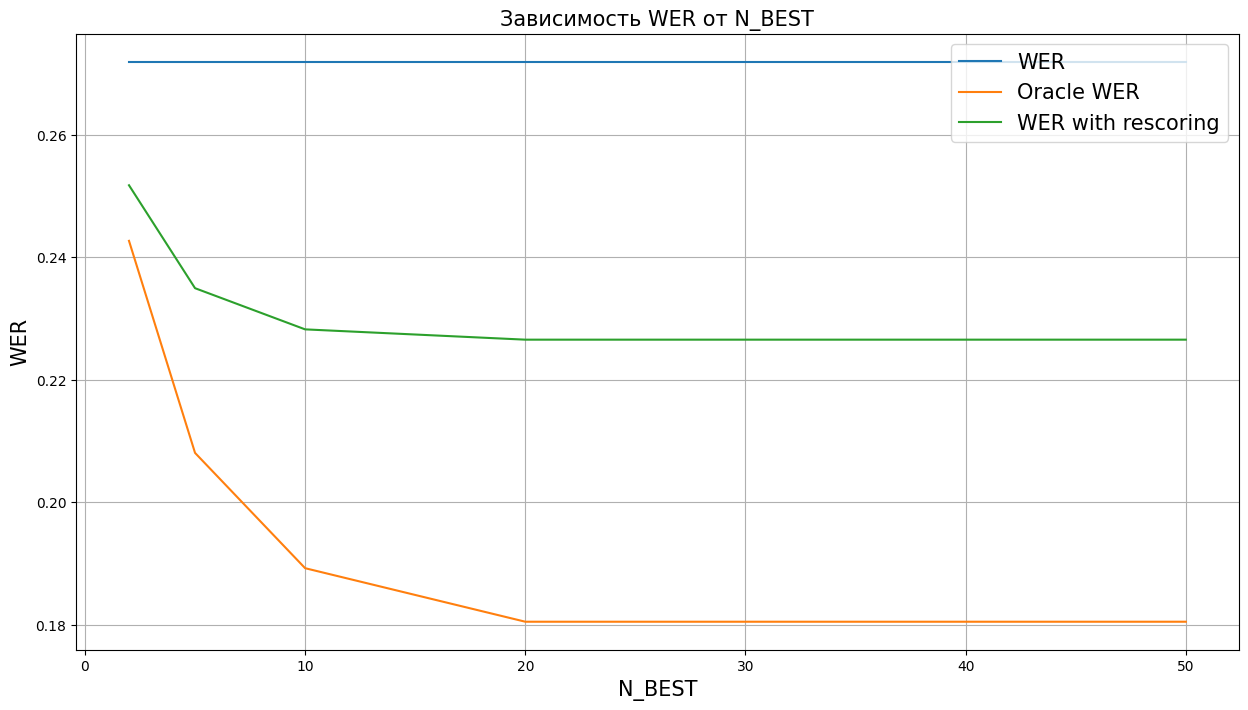

In [402]:
plt.figure(figsize=(15, 8))
plt.plot(N_BESTS, wer_results, label='WER')
plt.plot(N_BESTS, oracle_wer_results, label='Oracle WER')
plt.plot(N_BESTS, rescored_wer_results, label='WER with rescoring')
plt.ylabel('WER', fontsize=15)
plt.xlabel('N_BEST', fontsize=15)
plt.title('Зависимость WER от N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

In [ ]:
N_BEST = 10
BEAM_SIZES = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for n_best in n_bests:
    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=tokens,
        nbest=n_best,
        beam_size=BEAM_SIZE,
        sil_token=' ',
        blank_token='-',
    )
    wer, oracle_wer, rescored_wer = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
    wer_results.append(wer)
    oracle_wer_results.append(oracle_wer)
    rescored_wer_results.append(rescored_wer)